# Searchlight Analysis 
## with Representational Similarity Analysis method

Created for RSA Tutorial, LMG-MPIB, 12th April 2022,
<p>Author: Izabela Maria Sztuka(imsztuka@protonmail.com)

## General notes:
<p> The following script was created as an example of analysis pipeline for Searchlight (SA) using RSA method with RSA toolbox python version (it is python equivalent of the MATLAB toolbox). The SA is a multivariate technique that identifies a locally informative areas using small spherical subsets called 'searchlights' centred on every voxel. The mapped value for each voxel is derivative of the searchlight not individual voxel. It is primarily used for whole-brain analyses, however it is possible (and less computationally expernsive) to perform it on ROI only. Here, we will use the SA to identify the regions informative for the selected ARCH candidate models. We first, obtain searchlight accuracy map for each participant and then perform group-level analysis using one-sample t-test to obtain z-map of accuracies in searchlight. 
    
<p> Searchlight analysis was performed using rsa method with py-rsatoolbox.
https://rsatoolbox.readthedocs.io/en/latest/

<p> for details on SA see: Etzel, J. A., Zacks, J. M., & Braver, T. S. (2013). Searchlight analysis: promise, pitfalls, and potential. NeuroImage, 78, 261–269. https://doi.org/10.1016/j.neuroimage.2013.03.041    
    
    
#### packages needed to run it: 

- nilearn 0.8.1
- nibabel 3.2.1
- numpy  1.21.4
- matplotlib 3.5.0
- scipy 1.7.3
- pandas 1.3.4
- seaborn 0.11.2
- tabulate (to print the cluster table)

    


## Workflow:

1. Logistics. Loading necessary packages.
2. Helper functions.
3. Directories. CUSTOMISE HERE. 

<p> Group level analysis is performing one-sample ttest (with smoothing=3) with FDR correction. 
<p> The script is producing the z score files in .npy and .nii format.
<p> Opt. visualise the map interactively or in static.
    


**Logistics.

In [1]:
#!/usr/bin/python3
# ARCH-RSA searchlight second-level post rsa-method wholebrain searchlight.
from nilearn import datasets
import pandas as pd
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import image
from nilearn import plotting
from nilearn import masking
from nilearn.reporting import get_clusters_table
from glob import glob
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from nilearn.image import get_data, math_img
from scipy.stats import norm
import seaborn as sns
from nilearn.image import new_img_like
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from scipy import io
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight

/opt/anaconda3/envs/TR/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


**Helper functions**

In [4]:
# organise the RDM into upper triangular index and configure the matrices.
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

import matplotlib.colors
def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

**Directories**

In [6]:
# directories
# DIRECTORY TO BETAS
IN = '/Volumes/IMS_Drive/RSA_BIDS_2/derivatives/1Level/RSA_1stLevel_1stDeriv/'
# DIRECTORY TO RESULTS
OUT_brains = '/Volumes/IMS_Drive/RSA_BIDS_2/derivatives/py-searchlight/AN/Figures/'
ensure_dir(OUT_brains)
OUT_plots = '/Volumes/IMS_Drive/RSA_BIDS_2/derivatives/py-searchlight/AN/Plots/'
ensure_dir(OUT_plots)
OUT_scores = '/Volumes/IMS_Drive/RSA_BIDS_2/derivatives/py-searchlight/AN/Scores/'
ensure_dir(OUT_scores)
OUT_results = '/Volumes/IMS_Drive/RSA_BIDS_2/derivatives/py-searchlight/AN/Results/'
ensure_dir(OUT_results)
#where you save the resulting group-level z-score
grouplevel_z = '/Volumes/IMS_Drive/RSA_BIDS_2/derivatives/py-searchlight/Group_Level/z_score/'
ensure_dir(grouplevel_z)

**Speficy subject IDs**

In [7]:
subs_dir = ['sub-01','sub-02','sub-03','sub-04','sub-05']

**Subject-level Searchlight Analysis (loop)

sub-01 - images loaded
sub-01 - looking for searchlights


Finding searchlights...: 100%|████████| 229909/229909 [00:58<00:00, 3950.93it/s]


Found 212292 searchlights
sub-01 - creating brain RDMs


Calculating RDMs...: 100%|████████████████████| 100/100 [10:26<00:00,  6.27s/it]


sub-01 - loading subjects dissimilarity matrix


Evaluating models for each searchlight:   0%|        | 0/212292 [00:00<?, ?it/s]/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/e

sub-01 - running model comparison


/var/folders/4l/1x513zqj2nj3jkn998spd49ckc7mm4/T/ipykernel_12441/3114520131.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


sub-01 - scores saved and now in use for saving in version compatible with other applications
sub-01 - saving scores
End SearchLight for participant sub-01
sub-01 - saving scores


/opt/anaconda3/envs/TR/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sub-01 - saving distribution of correlations
sub-01 - saving plot of voxels above 99th percentile


/opt/anaconda3/envs/TR/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


sub-01 - finished
sub-02 - images loaded
sub-02 - looking for searchlights


Finding searchlights...: 100%|████████| 233154/233154 [00:57<00:00, 4067.95it/s]


Found 219254 searchlights
sub-02 - creating brain RDMs


Calculating RDMs...: 100%|████████████████████| 100/100 [10:44<00:00,  6.45s/it]


sub-02 - loading subjects dissimilarity matrix


Evaluating models for each searchlight:   0%|        | 0/219254 [00:00<?, ?it/s]/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/e

sub-02 - running model comparison


/var/folders/4l/1x513zqj2nj3jkn998spd49ckc7mm4/T/ipykernel_12441/3114520131.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


sub-02 - scores saved and now in use for saving in version compatible with other applications
sub-02 - saving scores
End SearchLight for participant sub-02
sub-02 - saving scores


/opt/anaconda3/envs/TR/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sub-02 - saving distribution of correlations
sub-02 - saving plot of voxels above 99th percentile
sub-02 - finished
sub-03 - images loaded
sub-03 - looking for searchlights


Finding searchlights...: 100%|████████| 223387/223387 [00:58<00:00, 3802.56it/s]


Found 204643 searchlights
sub-03 - creating brain RDMs


Calculating RDMs...: 100%|████████████████████| 100/100 [10:02<00:00,  6.03s/it]


sub-03 - loading subjects dissimilarity matrix


Evaluating models for each searchlight:   0%|        | 0/204643 [00:00<?, ?it/s]/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/e

sub-03 - running model comparison


/var/folders/4l/1x513zqj2nj3jkn998spd49ckc7mm4/T/ipykernel_12441/3114520131.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


sub-03 - scores saved and now in use for saving in version compatible with other applications
sub-03 - saving scores
End SearchLight for participant sub-03
sub-03 - saving scores


/opt/anaconda3/envs/TR/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sub-03 - saving distribution of correlations
sub-03 - saving plot of voxels above 99th percentile
sub-03 - finished
sub-04 - images loaded
sub-04 - looking for searchlights


Finding searchlights...: 100%|████████| 222343/222343 [01:03<00:00, 3491.62it/s]


Found 205773 searchlights
sub-04 - creating brain RDMs


Calculating RDMs...: 100%|████████████████████| 100/100 [09:39<00:00,  5.79s/it]


sub-04 - loading subjects dissimilarity matrix


Evaluating models for each searchlight:   0%|        | 0/205773 [00:00<?, ?it/s]/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/e

sub-04 - running model comparison


/var/folders/4l/1x513zqj2nj3jkn998spd49ckc7mm4/T/ipykernel_12441/3114520131.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


sub-04 - scores saved and now in use for saving in version compatible with other applications
sub-04 - saving scores
End SearchLight for participant sub-04
sub-04 - saving scores


/opt/anaconda3/envs/TR/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sub-04 - saving distribution of correlations
sub-04 - saving plot of voxels above 99th percentile
sub-04 - finished
sub-05 - images loaded
sub-05 - looking for searchlights


Finding searchlights...: 100%|████████| 233183/233183 [00:56<00:00, 4116.44it/s]


Found 215733 searchlights
sub-05 - creating brain RDMs


Calculating RDMs...: 100%|████████████████████| 100/100 [10:02<00:00,  6.03s/it]


sub-05 - loading subjects dissimilarity matrix


Evaluating models for each searchlight:   0%|        | 0/215733 [00:00<?, ?it/s]/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/rsatoolbox/inference/evaluate.py:255: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances = np.cov(evaluations[0], ddof=1) \
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/e

sub-05 - running model comparison


/var/folders/4l/1x513zqj2nj3jkn998spd49ckc7mm4/T/ipykernel_12441/3114520131.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


sub-05 - scores saved and now in use for saving in version compatible with other applications
sub-05 - saving scores
End SearchLight for participant sub-05
sub-05 - saving scores


/opt/anaconda3/envs/TR/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sub-05 - saving distribution of correlations
sub-05 - saving plot of voxels above 99th percentile
sub-05 - finished


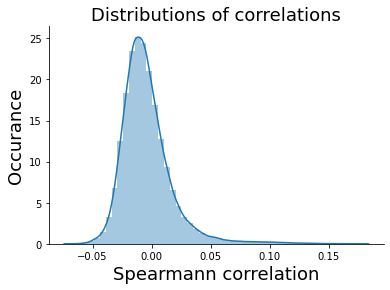

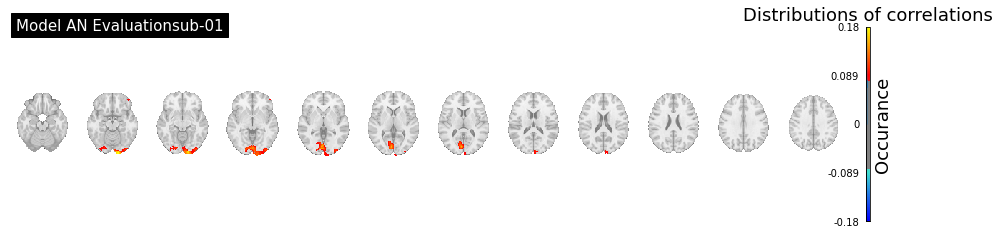

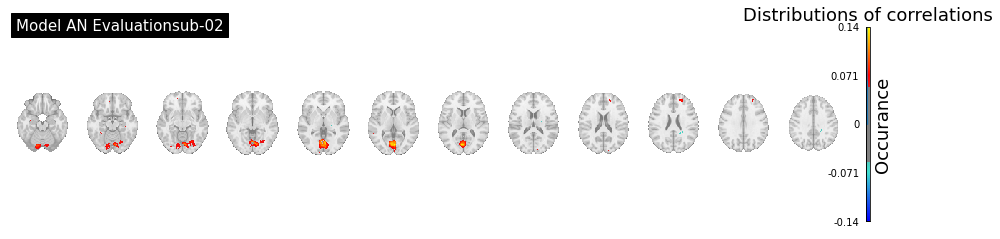

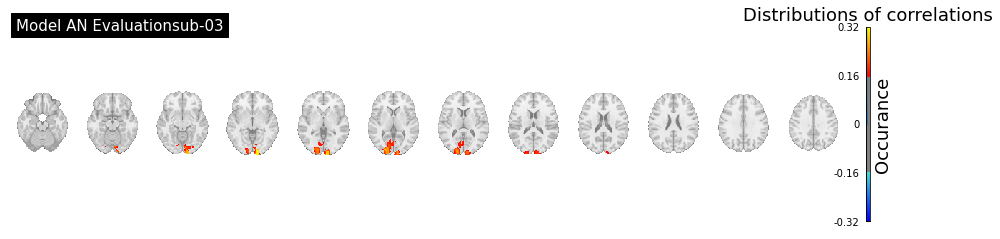

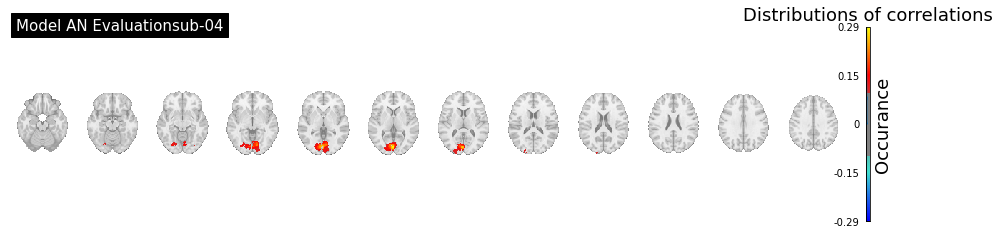

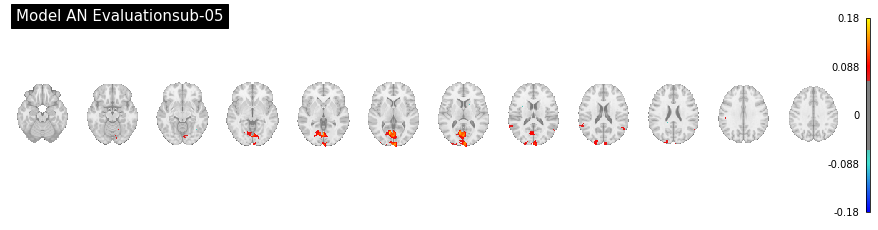

In [8]:
for i in range(len(subs_dir)):
# set this path to wherever you saved the folder containing the img-files
    data_folder =  os.path.join(IN, subs_dir[i])
    image_paths = list(glob(f"{data_folder}/beta_*.nii"))
    image_paths.sort()
    print(subs_dir[i]+' - images loaded')
# load one image to get the dimensions and make the mask
    tmp_img = nib.load(image_paths[0])
    affine_mat = tmp_img.affine
    dimsize = tmp_img.header.get_zooms()
# we infer the mask by looking at non-nan voxels
    mask = ~np.isnan(tmp_img.get_fdata())
    x, y, z = tmp_img.get_fdata().shape
# loop over all images
    data = np.zeros((len(image_paths), x, y, z))
    for x, im in enumerate(image_paths):
        data[x] = nib.load(im).get_fdata()
# only one pattern per image
    image_value = np.arange(len(image_paths))
# SPECIFY SEARCHLIGHT PARAMETERS
    print(subs_dir[i]+' - looking for searchlights')
    centers, neighbors = get_volume_searchlight(mask, radius=5, threshold=0.5)
# reshape data so we have n_observastions x n_voxels
    data_2d = data.reshape([data.shape[0], -1])
    data_2d = np.nan_to_num(data_2d)
# Get RDMs METHOD!
    print(subs_dir[i]+' - creating brain RDMs')
    SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='correlation')
# load sub specific file from matlab MDS file:
    print(subs_dir[i]+' - loading subjects dissimilarity matrix')
#load Model from general file (CUSTOMISE THE DIRECTORY):
    matlab_data = io.matlab.loadmat('/Users/sztuka/Documents/rsa-tutorial/rsa_searchlight/model_AN.mat')
    matlab_data = matlab_data['AN']
# This is difficult part:
    an_labels = np.array(['I-C-A-1.jpg','I-C-A-10.jpg','I-C-A-11.jpg','I-C-A-3.jpg','I-C-A-4.jpg','I-E-A-1.jpg','I-E-A-2.jpg','I-E-A-3.jpg','I-E-A-5.jpg','I-E-A-7.jpg','I-G-A-1.jpg','I-G-A-14.jpg','I-G-A-20.jpg','I-G-A-3.jpg','I-G-A-8.jpg','I-H-A-22.jpg','I-H-A-29.jpg','I-H-A-5.jpg','I-H-A-51.jpg','I-H-A-7.jpg','I-M-A-10.jpg','I-M-A-11.jpg','I-M-A-13.jpg','I-M-A-14.jpg','I-M-A-16.jpg','I-R-A-20.jpg','I-R-A-21.jpg','I-R-A-23.jpg','I-R-A-25.jpg','I-R-A-9.jpg','I-C-N-1.jpg','I-C-N-11.jpg','I-C-N-2.jpg','I-C-N-3.jpg','I-C-N-7.jpg','I-E-N-1.jpg','I-E-N-2.jpg','I-E-N-3.jpg','I-E-N-4.jpg','I-E-N-6.jpg','I-G-N-1.jpg','I-G-N-13.jpg','I-G-N-16.jpg','I-G-N-5.jpg','I-G-N-7.jpg','I-H-N-29.jpg','I-H-N-39.jpg','I-H-N-41.jpg','I-H-N-44.jpg','I-H-N-7.jpg','I-M-N-1.jpg','I-M-N-4.jpg','I-M-N-5.jpg','I-M-N-6.jpg','I-M-N-8.jpg','I-R-N-10.jpg','I-R-N-12.jpg','I-R-N-21.jpg','I-R-N-22.jpg','I-R-N-23.jpg'])
    an_RDM = matlab_data
    an_model = ModelFixed('AN', upper_tri(an_RDM))
# get the evaulation score for each voxel
    eval_results = evaluate_models_searchlight(SL_RDM, an_model, eval_fixed, method='spearman', n_jobs=3)
# We only have one model, but evaluations returns a list. By using float we just grab the value within that list
    print(subs_dir[i]+' - running model comparison')
    eval_score = [np.float(e.evaluations) for e in eval_results]
    print(subs_dir[i]+' - scores saved and now in use for saving in version compatible with other applications')
    file_n = 'ARCH_AN_score_'+ subs_dir[i]
    file_nFigures = os.path.join(OUT_scores, file_n)
    print(subs_dir[i]+' - saving scores')
    np.save(file_nFigures,eval_score)
# Create an 3D array, with the size of mask, and
    x, y, z = mask.shape
    RDM_brain = np.zeros([x*y*z])
    RDM_brain[list(SL_RDM.rdm_descriptors['voxel_index'])] = eval_score
    RDM_brain = RDM_brain.reshape([x, y, z])
    print('End SearchLight for participant ' + subs_dir[i])
# results for replication: (here you are saving RDM brain not only evaluation score)
    file_nb = 'ARCH_AN_RDMbrain_'+ subs_dir[i]+'.npy'
    file_nbFigures = os.path.join(OUT_scores, file_nb)
    print(subs_dir[i]+' - saving scores')
    np.save(file_nbFigures,RDM_brain)
    output_name = 'ARCH_SL_AN_result_'+ subs_dir[i]+'.nii.gz'
    output_dir = os.path.join(OUT_results,output_name)
    sl_result = RDM_brain.astype('double')  # Convert the output into a precision format that can be used by other applications
    sl_result[np.isnan(sl_result)] = 0  # Exchange nans with zero to ensure compatibility with other applications
    sl_nii = nib.Nifti1Image(sl_result, affine_mat)  # create the volume image
    hdr = sl_nii.header  # get a handle of the .nii file's header
    nib.save(sl_nii, output_dir)  # Save the volume
#plot results
    sns.distplot(eval_score)
    print(subs_dir[i]+' - saving distribution of correlations')
    plt.title('Distributions of correlations', size=18)
    plt.ylabel('Occurance', size=18)
    plt.xlabel('Spearmann correlation', size=18)
    sns.despine()
    #plt.show()
# sale the plot
    figure_name = 'ARCH_SL_AN_DOC_'+ subs_dir[i]
    filenameFigures = os.path.join(OUT_plots,figure_name)
    plt.savefig(filenameFigures,dpi=800)
# lets plot the voxels above the 99th percentile
    threshold = np.percentile(eval_score, 99)
    plot_img = new_img_like(tmp_img, RDM_brain)
    cmap = RDMcolormapObject()
    coords = range(-20, 40, 5)
    print(subs_dir[i]+' - saving plot of voxels above 99th percentile')
    fig = plt.figure(figsize=(12, 3))
    display = plotting.plot_stat_map(
        plot_img, colorbar=True, cut_coords=coords,threshold=threshold,
        display_mode='z', draw_cross=False, figure=fig,
        title=f'Model AN Evaluation'+ subs_dir[i], cmap=cmap,
        black_bg=False, annotate=False)
    #plt.show()
    figure_name = 'ARCH_SL_AN_'+ subs_dir[i]
    filenameFigures = os.path.join(OUT_brains, figure_name)
    plt.savefig(filenameFigures,dpi=800)
    print(subs_dir[i]+' - finished')

**Inspecting the results**

**Group-level inference**

In [10]:
# HELPER
#name of the model in dir and file name
# if model is in collective folder like Ratings, LLF or MDS then typy = 1 else it's 0
typy = 0
typt = 'LLF'
# model name
model_name = 'AN'
# if filename is different
another_name = model_name

# should be 34 all through.
n_samples = 34

# For dCNN ONLY: layer number
layer = '10'
# if using dCNN models =1 else keep 0
dCNN = 0
if dCNN == 1:
    print(model_name+layer)
else:
    print(model_name)

AN


In [11]:
# set properties
n_subjects=n_samples
if typy == 1:
    src = '/Users/sztuka/Desktop/Searchlight/Tardis_deriv/py-searchlight/py-searchlight/'+typt+'/'+model_name+'/Results/ARCH_SL_'+another_name+'_result_sub-*.nii.gz'
else:
    src = '/Users/sztuka/Desktop/Searchlight/Tardis_deriv/py-searchlight/py-searchlight/'+model_name+'/Results/ARCH_SL_'+another_name+'_result_sub-*.nii.gz'
# Load the accuracy maps from searchlight. 
data_folder =  src
cmap_filenames = list(glob(f"{data_folder}"))
cmap_filenames.sort()
tmp_img = nib.load(cmap_filenames[0])
affine_mat = tmp_img.affine
dimsize = tmp_img.header.get_zooms()
# Construct design matrix & model
design_matrix = pd.DataFrame([1] * n_samples, columns=['intercept'])
second_level_model = SecondLevelModel(smoothing_fwhm=3.0).fit(cmap_filenames, design_matrix=design_matrix)
#Estimate model
# output_type must be one of ['z_score', 'stat', 'p_value', 'effect_size', 'effect_variance', 'all']
z_map = second_level_model.compute_contrast(second_level_stat_type='t',output_type='z_score')
# save z_maps 
file_nb = 'ARCH_'+model_name+'_z_score.npy'
file_csv = 'ARCH_'+model_name+'_z_score.nii'
file_nbFigures = os.path.join(grouplevel_z, file_nb)
np.save(file_nbFigures,z_map)
sl_result = z_map 
sl_nii = nib.Nifti1Image(sl_result, affine_mat)  # create the volume image
hdr = sl_nii.header  # get a handle of the .nii file's header
output_dir = os.path.join(grouplevel_z, file_csv)
nib.save(sl_result, output_dir)  # Save the volume
print(model_name+' done deal!')

AN done deal!


**Plot uncorrected values**

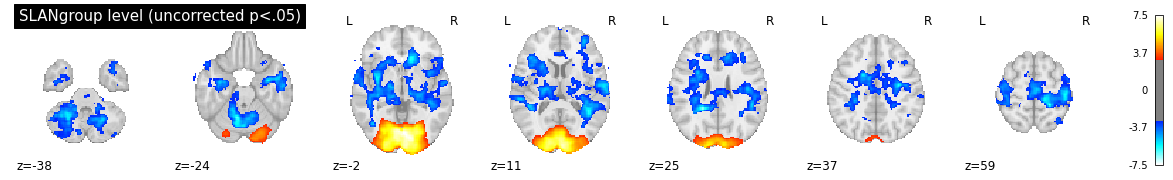

In [13]:
# threshold the second level contrast at uncorrected p < 0.05 and plot it.
p_val = 0.001
p001_unc = norm.isf(p_val)
display = plotting.plot_stat_map(
    z_map, threshold=p001_unc, colorbar=True, display_mode='z',
    title='SL'+model_name+'group level (uncorrected p<.05)')
# plot the results:
plotting.show()

**Perform FDR correction**

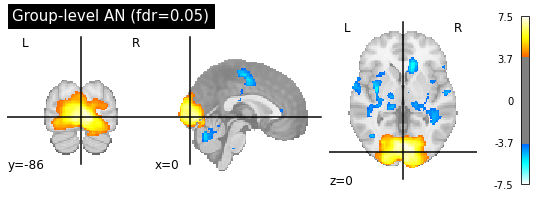

In [27]:
# Compute the fdr-corrected p = 0.05 threshold for these data
_, threshold = threshold_stats_img(z_map, alpha=.001,cluster_threshold = 20, height_control='fdr')
# Plot the second level contrast at the computed thresholds
plotting.plot_stat_map(
    z_map, threshold=threshold, colorbar=True,
    title='Group-level '+model_name+' (fdr=0.05)')
# plot the results: 
plotting.show()

**View interactively**

In [28]:
# create the view
view = plotting.view_img(z_map, threshold=threshold, colorbar=True,
    title='Group-level '+model_name+'(fdr=0.05)')
# view in the cell below
#view
# view in the browser
view.open_in_browser()